In [1]:
import pandas as pd
import numpy as np
import simfin as sf
import seaborn as sns
import os
from dotenv import load_dotenv
import klib
import shap
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics.pairwise import cosine_similarity
from xgboost import XGBRegressor
from utils import plot_correlation
from simfin.names import *

In [2]:
# RESOURCES

# https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard
# https://medium.com/@benjamin.phillips22/simple-regression-with-neural-networks-in-pytorch-313f06910379
# https://github.com/skorch-dev/skorch

In [3]:
# TODO

# 1. Build a Nearest Neighbor Model

In [86]:
# SETTINGS
# Set Pandas Options
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.8f}'.format

# Set your API-key for downloading data.
# If the API-key is 'free' then you will get the free data,
load_dotenv()
SIMFIN_API_KEY = os.getenv('SIMFIN_API_KEY')
sf.set_api_key(SIMFIN_API_KEY)

# Set the local directory where data-files are stored.
# The dir will be created if it does not already exist.
sf.set_data_dir('simfin_data/')

In [5]:
# Load the annual Income Statements for all companies in USA.
# The data is automatically downloaded if you don't have it already.
# Quarterly Data is Needed for the Growth Signals Below
REFRESH_DAYS = 1

# Common
income_df = sf.load_income(variant='ttm', market='us', refresh_days=REFRESH_DAYS)
income_quarterly_df = sf.load_income(variant='quarterly', market='us', refresh_days=REFRESH_DAYS)

balance_df = sf.load_balance(variant='ttm', market='us', refresh_days=REFRESH_DAYS)
balance_quarterly_df = sf.load_balance(variant='quarterly', market='us', refresh_days=REFRESH_DAYS)

cashflow_df = sf.load_cashflow(variant='ttm', market='us', refresh_days=REFRESH_DAYS)
cashflow_quarterlay_df = sf.load_cashflow(variant='quarterly', market='us', refresh_days=REFRESH_DAYS)

derived_df = sf.load_derived(variant='ttm', market='us', refresh_days=REFRESH_DAYS)

cache_args = {'cache_name': 'financial_signals',
              'cache_refresh' : 1}

fin_signal_df = sf.fin_signals(df_income_ttm=income_df,
                                df_balance_ttm=balance_df,
                                df_cashflow_ttm=cashflow_df,
                                **cache_args)

cache_args = {'cache_name': 'growth_signals',
              'cache_refresh' : 1}

growth_signal_df = sf.growth_signals(df_income_ttm=income_df,
                  df_income_qrt=income_quarterly_df,
                  df_balance_ttm=balance_df,
                  df_balance_qrt=balance_quarterly_df,
                  df_cashflow_ttm=cashflow_df,
                  df_cashflow_qrt=cashflow_quarterlay_df,
                  **cache_args)

# BANKS
income_banks_df = sf.load_income_banks(variant='ttm', market='us', refresh_days=REFRESH_DAYS)
balance_banks_df = sf.load_balance_banks(variant='ttm', market='us', refresh_days=REFRESH_DAYS)
cashflow_banks_df = sf.load_cashflow_banks(variant='ttm', market='us', refresh_days=REFRESH_DAYS)
derived_banks_df = sf.load_derived_banks(variant='ttm', market='us', refresh_days=REFRESH_DAYS)

#INSURANCE
income_insurance_df = sf.load_income_insurance(variant='ttm', market='us', refresh_days=REFRESH_DAYS)
balance_insurance_df = sf.load_balance_insurance(variant='ttm', market='us', refresh_days=REFRESH_DAYS)
cashflow_insurance_df = sf.load_cashflow_insurance(variant='ttm', market='us', refresh_days=REFRESH_DAYS)
derived_insurance_df = sf.load_derived_insurance(variant='ttm', market='us', refresh_days=REFRESH_DAYS)

# Shared
shareprices_df = sf.load_shareprices(variant='daily', market='us', refresh_days=REFRESH_DAYS)
company_df = sf.load_companies(market='us', refresh_days=REFRESH_DAYS)
industry_df = sf.load_industries(refresh_days=REFRESH_DAYS)

Dataset "us-income-ttm" on disk (1 days old).
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
Dataset "us-income-quarterly" on disk (1 days old).
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
Dataset "us-balance-ttm" on disk (1 days old).
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
Dataset "us-balance-quarterly" on disk (1 days old).
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
Dataset "us-cashflow-ttm" on disk (1 days old).
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
Dataset "us-cashflow-quarterly" on disk (1 days old).
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
Dataset "us-derived-ttm" on disk (1 days old).
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
Cache-file 'fin_signals-financial_signals.pi

In [6]:
# Common
# Remove Columns that exist in other Fundamental DataFrames
balance_columns = balance_df.columns[~balance_df.columns.isin(set().union(income_df.columns))]
cashflow_columns = cashflow_df.columns[~cashflow_df.columns.isin(set().union(income_df.columns))]
derived_df_columns = derived_df.columns[~derived_df.columns.isin(set().union(income_df.columns, 
                                                                             growth_signal_df.columns, 
                                                                             fin_signal_df.columns))]

# Merge the fundamental data into a single dataframe
fundamental_df = income_df.join(balance_df[balance_columns]
                               ).join(cashflow_df[cashflow_columns]
                                     ).join(fin_signal_df
                                           ).join(growth_signal_df
                                                 ).join(derived_df[derived_df_columns])


# Banks
# Remove Columns that exist in other Fundamental DataFrames
balance_columns = balance_banks_df.columns[~balance_banks_df.columns.isin(set().union(income_banks_df.columns))]
cashflow_columns = cashflow_banks_df.columns[~cashflow_banks_df.columns.isin(set().union(income_banks_df.columns))]
derived_df_columns = derived_banks_df.columns[~derived_banks_df.columns.isin(set().union(income_banks_df.columns))]

# Merge the fundamental data into a single dataframe
fundamental_banks_df = income_banks_df.join(balance_banks_df[balance_columns]
                               ).join(cashflow_banks_df[cashflow_columns]
                                     ).join(derived_banks_df[derived_df_columns])

# Insurance
# Remove Columns that exist in other Fundamental DataFrames
balance_columns = balance_insurance_df.columns[~balance_insurance_df.columns.isin(set().union(income_insurance_df.columns))]
cashflow_columns = cashflow_insurance_df.columns[~cashflow_insurance_df.columns.isin(set().union(income_insurance_df.columns))]
derived_df_columns = derived_insurance_df.columns[~derived_insurance_df.columns.isin(set().union(income_insurance_df.columns))]

# Merge the fundamental data into a single dataframe
fundamental_insurance_df = income_insurance_df.join(balance_insurance_df[balance_columns]
                               ).join(cashflow_insurance_df[cashflow_columns]
                                     ).join(derived_insurance_df[derived_df_columns])

In [7]:
# fundamental_df = fundamental_df[use_cols]
# fundamental_banks_df = fundamental_banks_df[use_cols]
# fundamental_insurance_df = fundamental_insurance_df[use_cols]

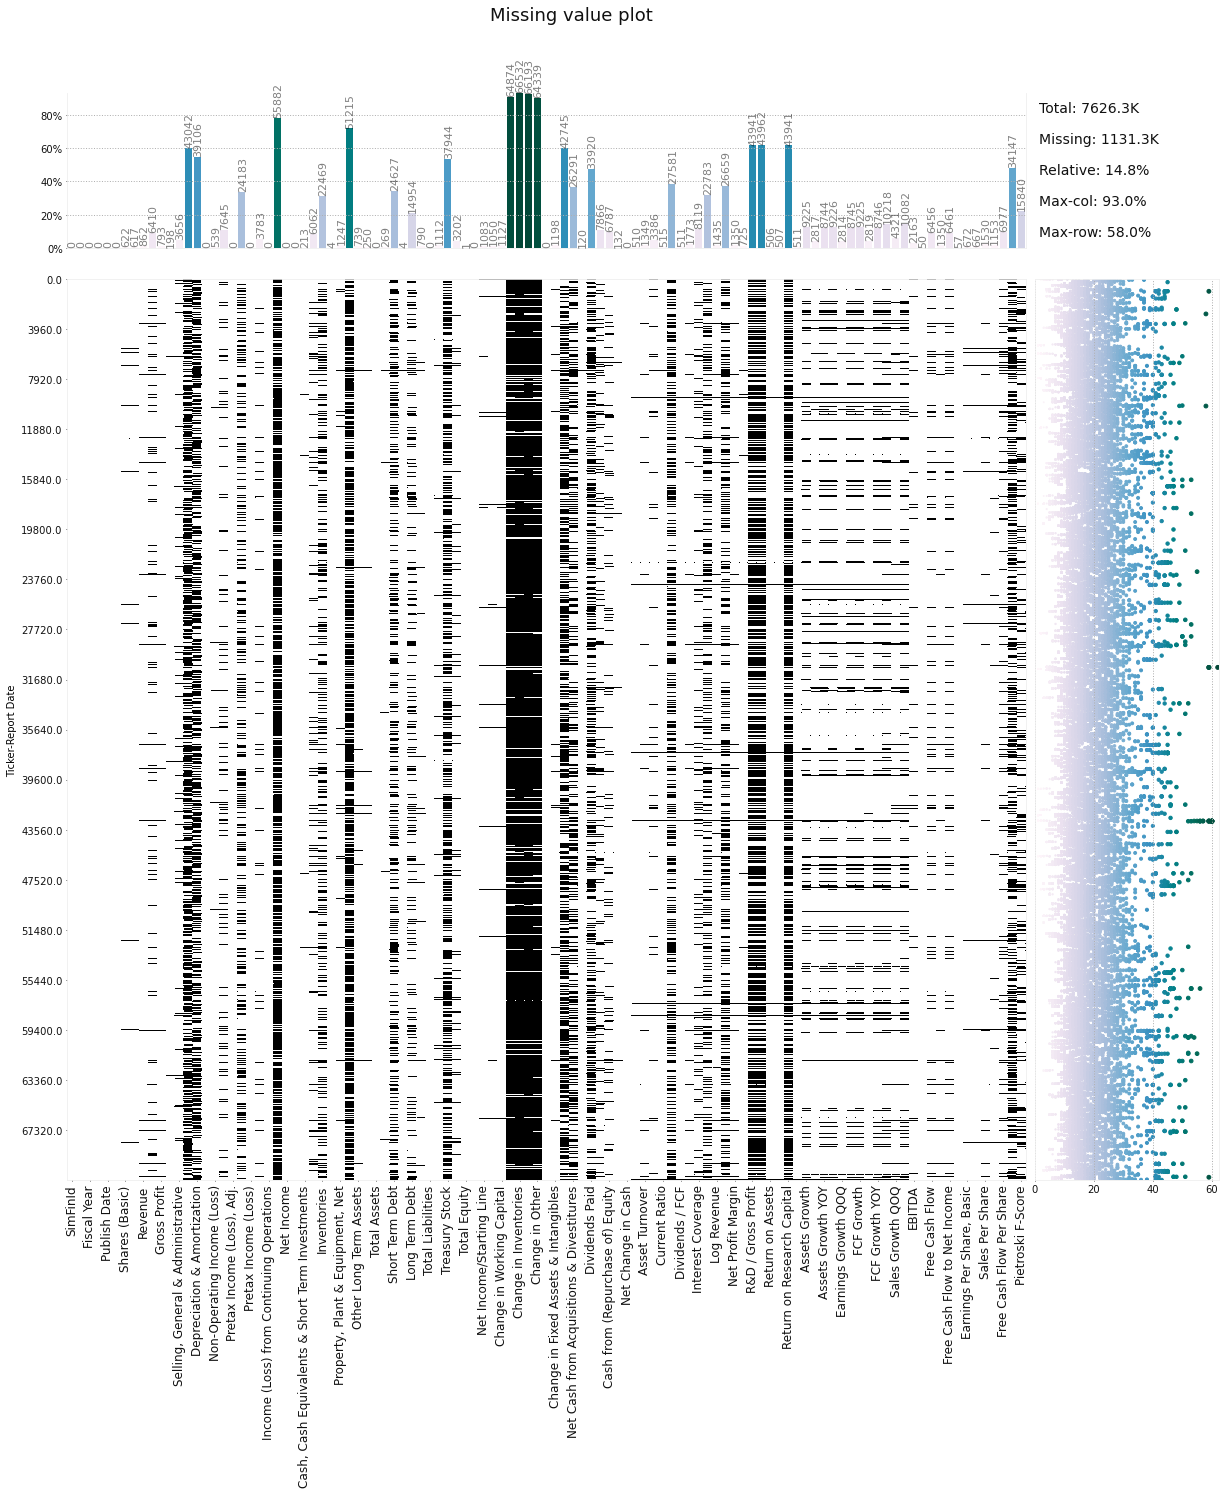

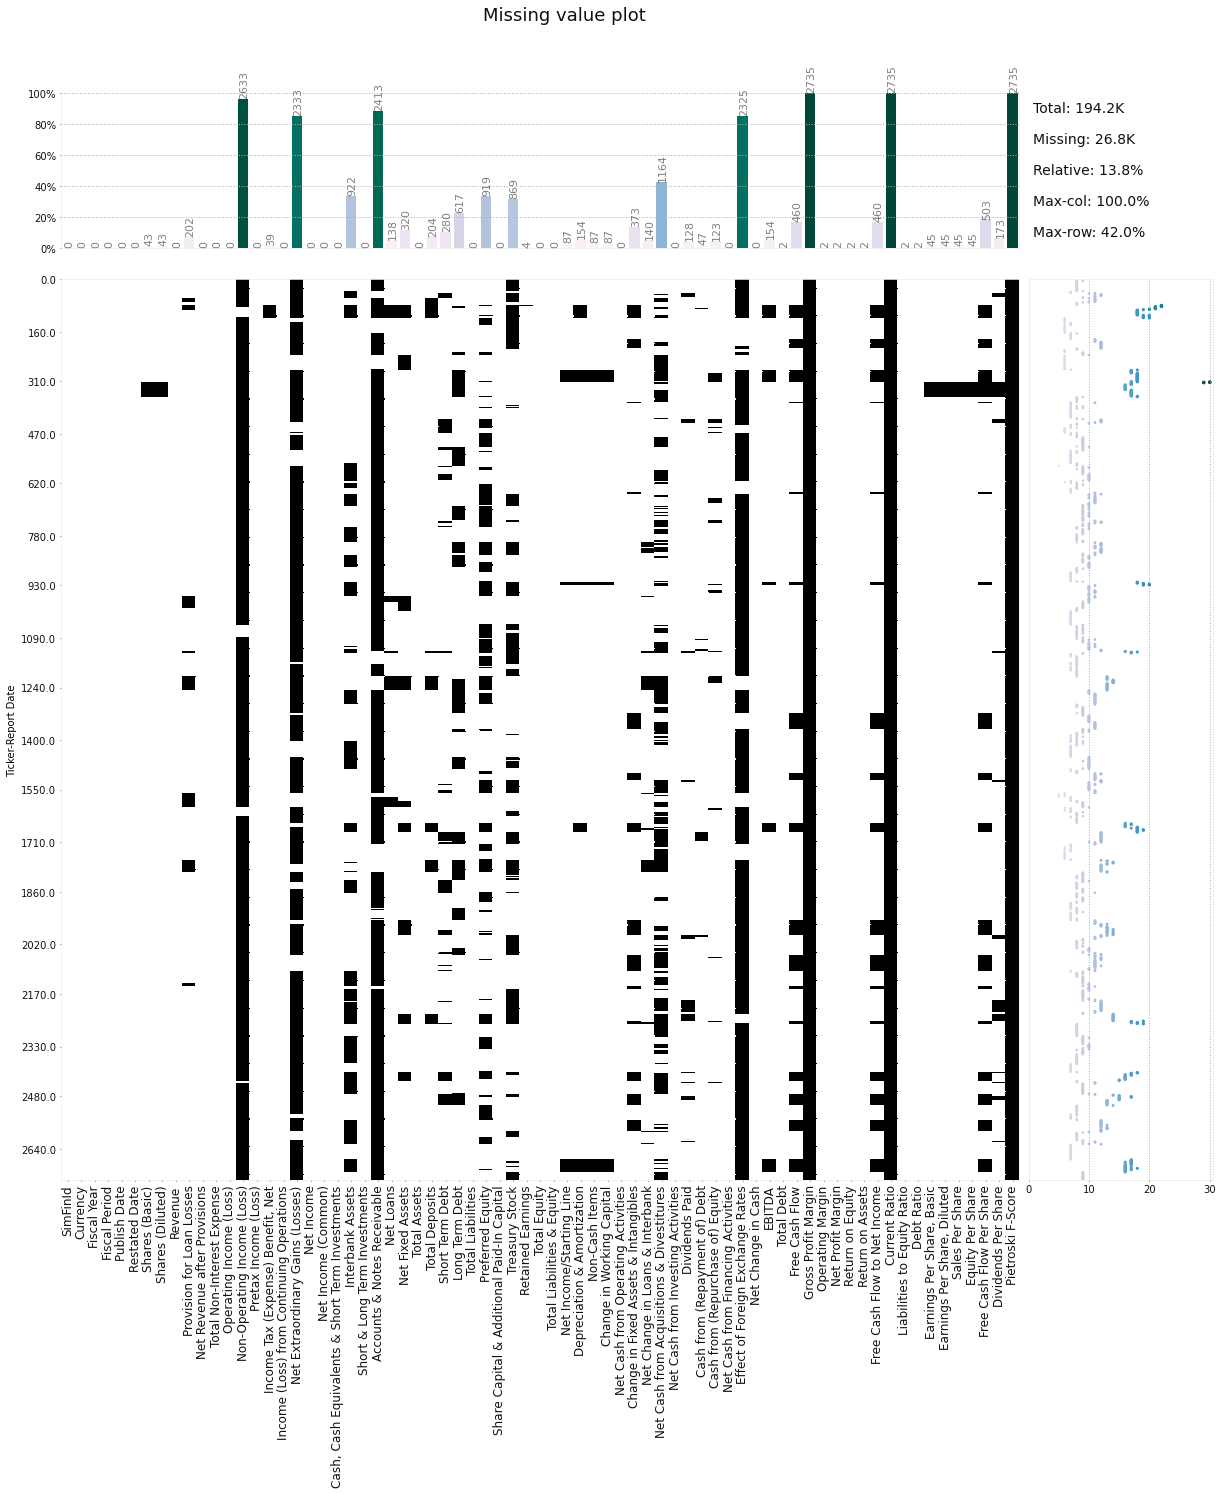

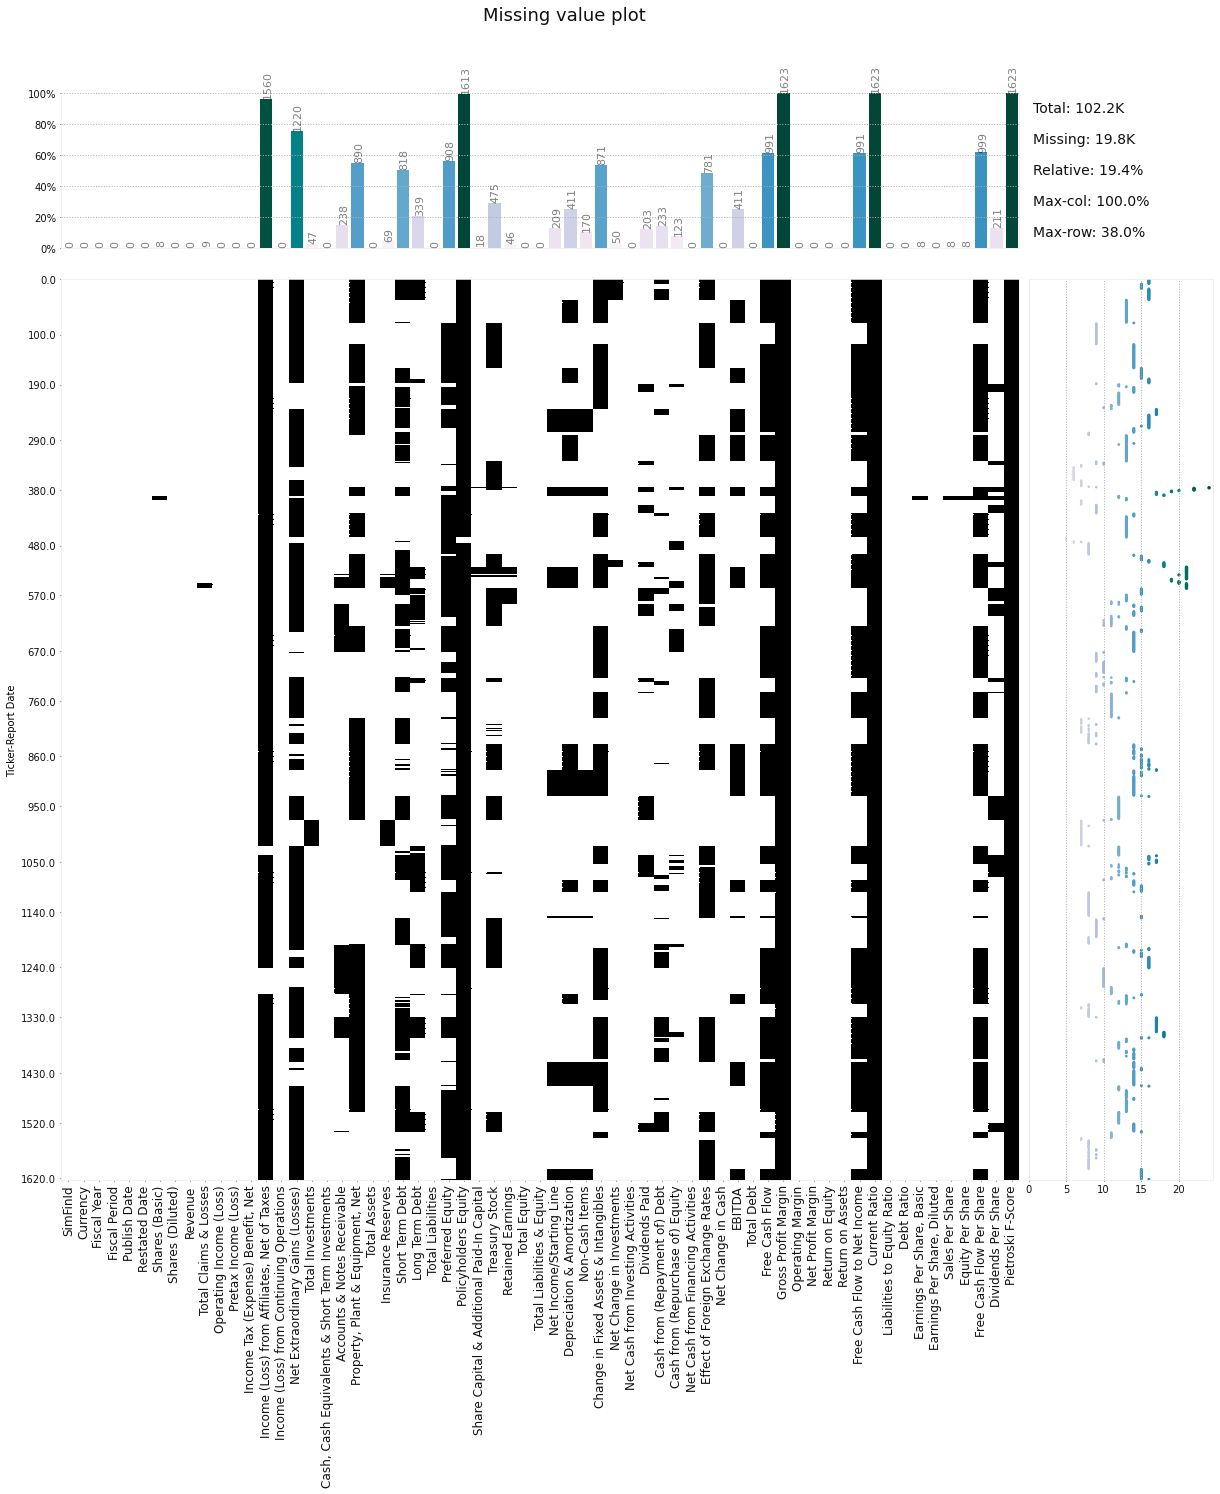

In [8]:
klib.missingval_plot(fundamental_df);
klib.missingval_plot(fundamental_banks_df);
klib.missingval_plot(fundamental_insurance_df);

In [9]:
# Drop Columns with more then 1-thresh nan values
thresh=0.7
fundamental_df = fundamental_df.dropna(thresh=int(thresh*len(fundamental_df)), axis=1)
fundamental_banks_df = fundamental_banks_df.dropna(thresh=int(thresh*len(fundamental_banks_df)), axis=1)
fundamental_insurance_df = fundamental_insurance_df.dropna(thresh=int(thresh*len(fundamental_insurance_df)), axis=1)

In [10]:
# Drop Duplicate Index
fundamental_df = fundamental_df[~fundamental_df.index.duplicated(keep='first')]
fundamental_banks_df = fundamental_banks_df[~fundamental_banks_df.index.duplicated(keep='first')]
fundamental_insurance_df = fundamental_insurance_df[~fundamental_insurance_df.index.duplicated(keep='first')]

In [11]:
# Replace Report Date with the Publish Date because the Publish Date is when the Fundamentals are known to the Public 
fundamental_df['Published Date'] = fundamental_df['Publish Date'] 
fundamental_df = fundamental_df.reset_index().set_index(['Ticker','Publish Date'])

fundamental_banks_df['Published Date'] = fundamental_banks_df['Publish Date'] 
fundamental_banks_df = fundamental_banks_df.reset_index().set_index(['Ticker','Publish Date'])

fundamental_insurance_df['Published Date'] = fundamental_insurance_df['Publish Date'] 
fundamental_insurance_df = fundamental_insurance_df.reset_index().set_index(['Ticker','Publish Date'])

In [33]:
# Merge Fundamental with Stock Prices

# downsample share prices to monthly
shareprices_df = sf.resample(df=shareprices_df[['Close']], rule='M', method='mean')

common_df = sf.reindex(df_src=fundamental_df, df_target=shareprices_df, group_index=TICKER, method='ffill'
               ).dropna(how='all').join(shareprices_df)

banks_df = sf.reindex(df_src=fundamental_banks_df, df_target=shareprices_df, group_index=TICKER, method='ffill'
               ).dropna(how='all').join(shareprices_df)

insurance_df = sf.reindex(df_src=fundamental_insurance_df, df_target=shareprices_df, group_index=TICKER, method='ffill'
               ).dropna(how='all').join(shareprices_df)

In [34]:
# # Add Company Attributes
# company_df = company_df.merge(industry_df, left_on='IndustryId', right_index=True, how='left', validate='many_to_one')
# df = df.reset_index().merge(company_df, on='SimFinId', how='left', validate='many_to_one').set_index(['Ticker', 'Date'])

In [35]:
# Common
# Clean Up
common_df = common_df.drop(['SimFinId', 'Currency', 'Fiscal Year', 'Report Date', 'Restated Date', 'Fiscal Period', 'Published Date'], axis=1)
common_df = common_df[common_df['Close'] <= common_df.loc['AMZN']['Close'].max()] # Remove Share Prices Over Amazon Share Price
common_df = common_df.dropna(subset=['Shares (Basic)', 'Shares (Diluted)', 'Revenue', 'Earnings Growth'])
common_df = common_df.replace([np.inf, -np.inf], 0)
common_df = common_df.fillna(0)

# Banks
# Clean Up
banks_df = banks_df.drop(['SimFinId', 'Currency', 'Fiscal Year', 'Report Date', 'Restated Date', 'Fiscal Period', 'Published Date'], axis=1)
banks_df = banks_df.dropna(subset=['Shares (Basic)', 'Shares (Diluted)', 'Revenue'])
banks_df = banks_df.replace([np.inf, -np.inf], 0)
banks_df = banks_df.fillna(0)

# Insurance
# Clean Up
insurance_df = insurance_df.drop(['SimFinId', 'Currency', 'Fiscal Year', 'Report Date', 'Restated Date', 'Fiscal Period', 'Published Date'], axis=1)
insurance_df = insurance_df.dropna(subset=['Shares (Basic)', 'Shares (Diluted)', 'Revenue']) # Drop Missing Sector/Industry Data
insurance_df = insurance_df.replace([np.inf, -np.inf], 0)
insurance_df = insurance_df.fillna(0)

In [36]:
# common
# Calculate Fundamental Data as per share
non_per_share_cols = ['Currency', 'Fiscal Year', 'Fiscal Period', 'Published Date',
                      'Restated Date', 'Shares (Basic)', 'Shares (Diluted)', 'Close',
                      ] + fin_signal_df.columns.tolist() + growth_signal_df.columns.tolist() + derived_df_columns.difference([ 'EBITDA', 'Total Debt', 'Free Cash Flow']).tolist() 

per_share_cols = common_df.columns[~common_df.columns.isin(non_per_share_cols)]

common_df[per_share_cols] =  common_df[per_share_cols].div(common_df['Shares (Diluted)'], axis=0)

# Banks
# Calculate Fundamental Data as per share
non_per_share_cols = ['Currency', 'Fiscal Year', 'Fiscal Period', 'Published Date',
                      'Restated Date', 'Shares (Basic)', 'Shares (Diluted)', 'Close',
                      ] + derived_df_columns.difference([ 'EBITDA', 'Total Debt', 'Free Cash Flow']).tolist() 

per_share_cols = banks_df.columns[~banks_df.columns.isin(non_per_share_cols)]

banks_df[per_share_cols] =  banks_df[per_share_cols].div(banks_df['Shares (Diluted)'], axis=0)

# Insurance
# Calculate Fundamental Data as per share
non_per_share_cols = ['Currency', 'Fiscal Year', 'Fiscal Period', 'Published Date',
                      'Restated Date', 'Shares (Basic)', 'Shares (Diluted)', 'Close',
                      ] + derived_df_columns.difference([ 'EBITDA', 'Total Debt', 'Free Cash Flow']).tolist() 

per_share_cols = insurance_df.columns[~insurance_df.columns.isin(non_per_share_cols)]

banks_df[per_share_cols] =  insurance_df[per_share_cols].div(insurance_df['Shares (Diluted)'], axis=0)

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


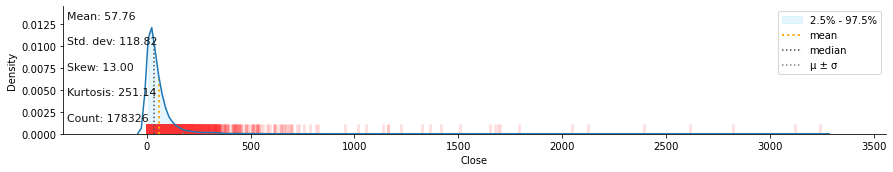

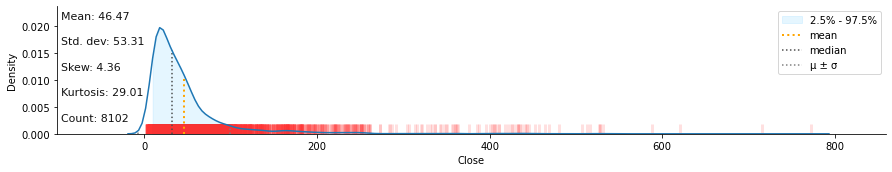

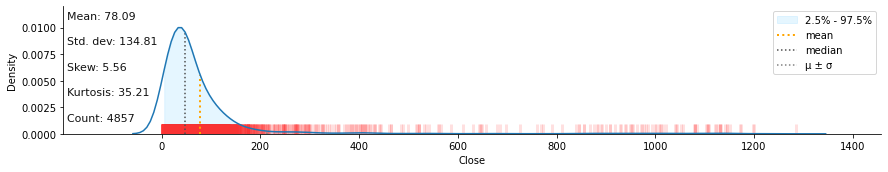

In [37]:
klib.dist_plot(common_df.Close);
klib.dist_plot(banks_df.Close);
klib.dist_plot(insurance_df.Close);

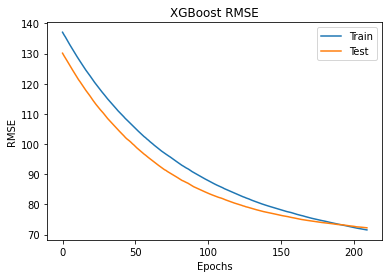

            R2 Score  RMSE
Train/Test                
Train           0.57 71.57
Test            0.52 72.27


Feature Importance


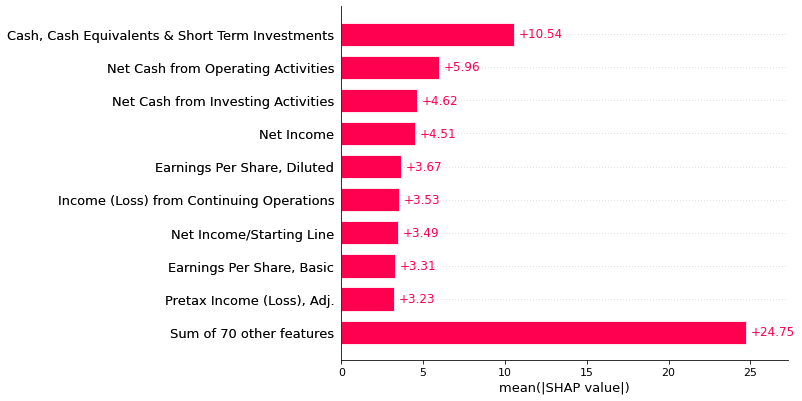

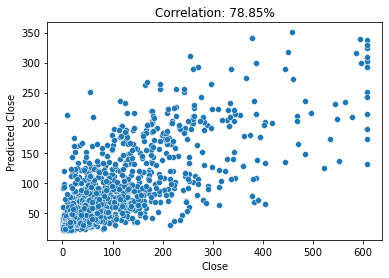

In [71]:
# Common
# List of all unique stock-tickers in the dataset.
tickers = common_df.reset_index()[TICKER].unique()
tickers_train, tickers_test = train_test_split(tickers, train_size=0.70, random_state=20)

model_df = common_df[common_df.index.get_level_values(1) == common_df.index.get_level_values(1).max()]
model_df = sf.winsorize(model_df, clip=True, columns=['Close'], quantile=0.01)

train = model_df.loc[tickers_train]
test = model_df.loc[tickers_test]

# DataFrames with signals for training- and test-sets.
X = model_df.drop(columns=['Close'])
X_train = train.drop(columns=['Close'])
X_test = test.drop(columns=['Close'])

# DataFrames with stock-returns for training- and test-sets.
y = model_df['Close']
y_train = train['Close']
y_test = test['Close']

# Model Building
common_model = XGBRegressor(learning_rate=0.01,
                     max_depth=2,
                     subsample=.5,
                     colsample_bylevel=0.7,
                     colsample_bytree=0.7,
                     n_estimators=210)

# https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/
eval_set = [(X_train, y_train), (X_test, y_test)]
common_model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

# retrieve performance metrics
results = common_model.evals_result()
results_df = pd.DataFrame([pd.Series(results['validation_0']['rmse'], name='Train'),
                           pd.Series(results['validation_1']['rmse'], name='Test')]).T

sns.lineplot(data=results_df, dashes=False)
plt.ylabel('RMSE')
plt.xlabel('Epochs')
plt.title('XGBoost RMSE')
plt.show()

y_train_pred = common_model.predict(X_train)
y_test_pred = common_model.predict(X_test)
# y_pred = common_model.predict(X)

data = {
    'Train/Test':['Train', 'Test'],
    'R2 Score':[],
    'RMSE':[]
}

data['R2 Score'].append(r2_score(y_train, y_train_pred))
data['R2 Score'].append(r2_score(y_test, y_test_pred))

data['RMSE'].append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
data['RMSE'].append(np.sqrt(mean_squared_error(y_test, y_test_pred)))

print(pd.DataFrame(data).set_index('Train/Test'))

# Shap Explainer
explainer = shap.TreeExplainer(common_model)
shap_values = explainer(X)
print('\n\nFeature Importance')
shap.plots.bar(shap_values, max_display=10)

# Correlation Plot
plot_correlation(common_model, X, y)

df = common_df.copy()
common_model.fit(X, y, verbose=False)
df['Predicted Close'] = common_model.predict(df.drop(['Close'], axis=1))
df['Model'] = 'Common'

In [109]:
# Similiraty

number_of_features = 15
ticker = 'ELY'

important_featurs = pd.Series(common_model.feature_importances_, index = X.columns).sort_values(ascending=False).index[:number_of_features]
tickers = X.index.get_level_values(0)
pd.DataFrame(cosine_similarity(X[important_featurs]), index=tickers, columns=tickers).loc[ticker].sort_values(ascending=False)

Ticker
ELY     1.00000000
WNC     0.99840111
BMY     0.99644258
IPHI    0.99572552
WWW     0.99496839
           ...    
RIHT   -0.07870434
SLNM   -0.09538169
SCRH   -0.10745464
TGLO   -0.14888194
FLLZ   -0.15267854
Name: ELY, Length: 1746, dtype: float64

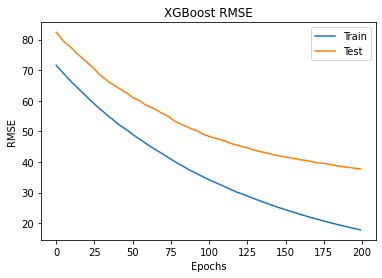

            R2 Score  RMSE
Train/Test                
Train           0.84 17.80
Test            0.47 37.73


Feature Importance


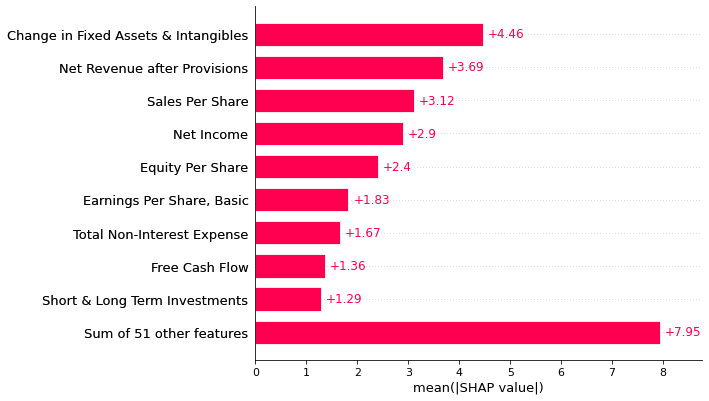

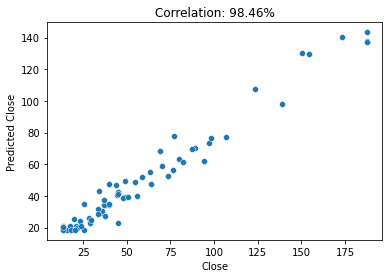

In [64]:
# Banks

# List of all unique stock-tickers in the dataset.
tickers = banks_df.reset_index()[TICKER].unique()
tickers_train, tickers_test = train_test_split(tickers, train_size=0.60, random_state=69420)

model_df = banks_df[banks_df.index.get_level_values(1) == banks_df.index.get_level_values(1).max()]
model_df = sf.winsorize(model_df, clip=True, columns=['Close'], quantile=0.05)

train = model_df.loc[tickers_train]
test = model_df.loc[tickers_test]

# DataFrames with signals for training- and test-sets.
X = model_df.drop(columns=['Close'])
X_train = train.drop(columns=['Close'])
X_test = test.drop(columns=['Close'])

# DataFrames with stock-returns for training- and test-sets.
y = model_df['Close']
y_train = train['Close']
y_test = test['Close']


# Model Building

bank_model = XGBRegressor(learning_rate=0.01, 
                     max_depth=2,
                     subsample=.8,
                     colsample_bylevel=0.7,
                     colsample_bytree=0.7,
#                      reg_lambda=0.1,
                     n_estimators=200) 

# https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/
eval_set = [(X_train, y_train), (X_test, y_test)]
bank_model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

# retrieve performance metrics
results = bank_model.evals_result()
results_df = pd.DataFrame([pd.Series(results['validation_0']['rmse'], name='Train'),
                           pd.Series(results['validation_1']['rmse'], name='Test')]).T

sns.lineplot(data=results_df, dashes=False)
plt.ylabel('RMSE')
plt.xlabel('Epochs')
plt.title('XGBoost RMSE')
plt.show()

y_train_pred = bank_model.predict(X_train)
y_test_pred = bank_model.predict(X_test)
y_pred = bank_model.predict(X)

data = {
    'Train/Test':['Train', 'Test'],
    'R2 Score':[],
    'RMSE':[]
}

data['R2 Score'].append(r2_score(y_train, y_train_pred))
data['R2 Score'].append(r2_score(y_test, y_test_pred))

data['RMSE'].append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
data['RMSE'].append(np.sqrt(mean_squared_error(y_test, y_test_pred)))

print(pd.DataFrame(data).set_index('Train/Test'))

# Shap Explainer
explainer = shap.TreeExplainer(bank_model)
shap_values = explainer(X)
print('\n\nFeature Importance')
shap.plots.bar(shap_values, max_display=10)

# Correlation Plot
plot_correlation(bank_model, X, y)

df = banks_df.copy()
bank_model.fit(X, y, verbose=False)
df['Predicted Close'] = bank_model.predict(df.drop(['Close'], axis=1))
df['Model'] = 'Common'

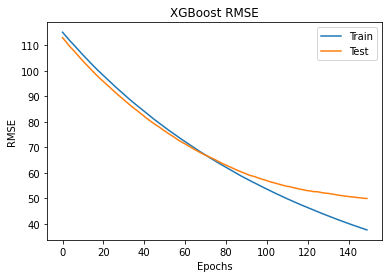

            R2 Score  RMSE
Train/Test                
Train           0.77 37.66
Test            0.42 49.99


Feature Importance


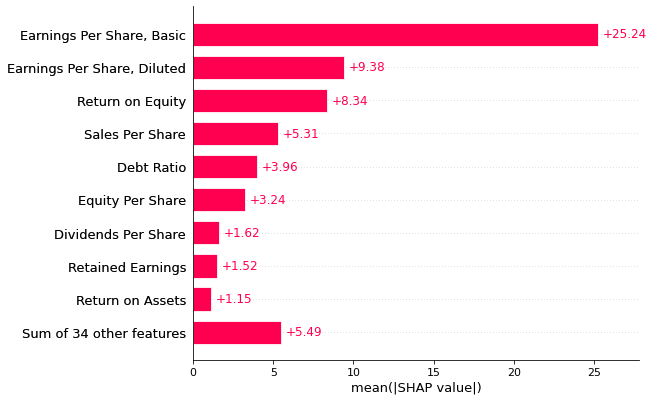

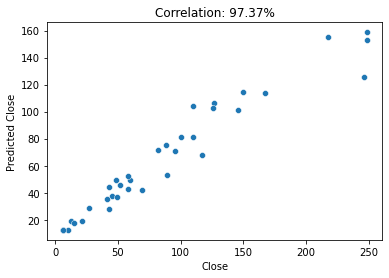

In [63]:
# Insurance

# List of all unique stock-tickers in the dataset.
tickers = insurance_df.reset_index()[TICKER].unique()
tickers_train, tickers_test = train_test_split(tickers, train_size=0.60, random_state=69420)

model_df = insurance_df[insurance_df.index.get_level_values(1) == insurance_df.index.get_level_values(1).max()]
model_df = sf.winsorize(model_df, clip=True, columns=['Close'], quantile=0.08)

train = model_df.loc[tickers_train]
test = model_df.loc[tickers_test]

# DataFrames with signals for training- and test-sets.
X = model_df.drop(columns=['Close'])
X_train = train.drop(columns=['Close'])
X_test = test.drop(columns=['Close'])

# DataFrames with stock-returns for training- and test-sets.
y = model_df['Close']
y_train = train['Close']
y_test = test['Close']

# Model Building

insurance_model = XGBRegressor(learning_rate=0.01, 
                     max_depth=2,
                     subsample=1,
                     colsample_bylevel=0.7,
                     colsample_bytree=0.7,
                     n_estimators=150)

# https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/
eval_set = [(X_train, y_train), (X_test, y_test)]
insurance_model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

# retrieve performance metrics
results = insurance_model.evals_result()
results_df = pd.DataFrame([pd.Series(results['validation_0']['rmse'], name='Train'),
                           pd.Series(results['validation_1']['rmse'], name='Test')]).T

sns.lineplot(data=results_df, dashes=False)
plt.ylabel('RMSE')
plt.xlabel('Epochs')
plt.title('XGBoost RMSE')
plt.show()

y_train_pred = insurance_model.predict(X_train)
y_test_pred = insurance_model.predict(X_test)
y_pred = insurance_model.predict(X)

data = {
    'Train/Test':['Train', 'Test'],
    'R2 Score':[],
    'RMSE':[]
}

data['R2 Score'].append(r2_score(y_train, y_train_pred))
data['R2 Score'].append(r2_score(y_test, y_test_pred))

data['RMSE'].append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
data['RMSE'].append(np.sqrt(mean_squared_error(y_test, y_test_pred)))

print(pd.DataFrame(data).set_index('Train/Test'))

# Shap Explainer
explainer = shap.TreeExplainer(insurance_model)
shap_values = explainer(X)
print('\n\nFeature Importance')
shap.plots.bar(shap_values, max_display=10)

# Correlation Plot
plot_correlation(insurance_model, X, y)

df = insurance_df.copy()
insurance_model.fit(X, y, verbose=False)
df['Predicted Close'] = insurance_model.predict(df.drop(['Close'], axis=1))
df['Model'] = 'Common'

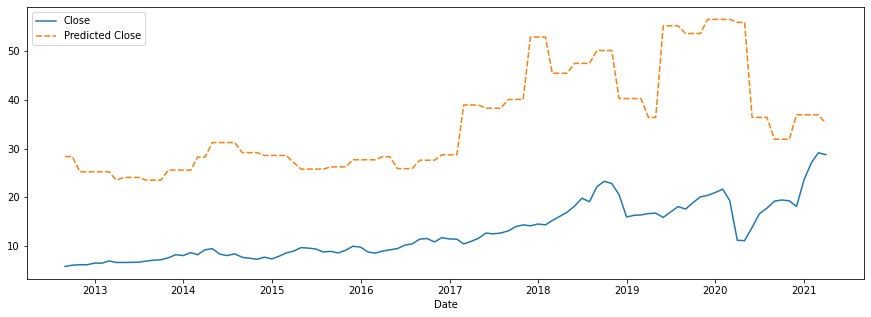

In [69]:
# Create Single Stock Analyzer
ticker = 'ELY'

data = df.loc[ticker][['Close', 'Predicted Close']]
plt.figure(figsize=(15,5))
sns.lineplot(data=df.loc[ticker][['Close', 'Predicted Close']]);

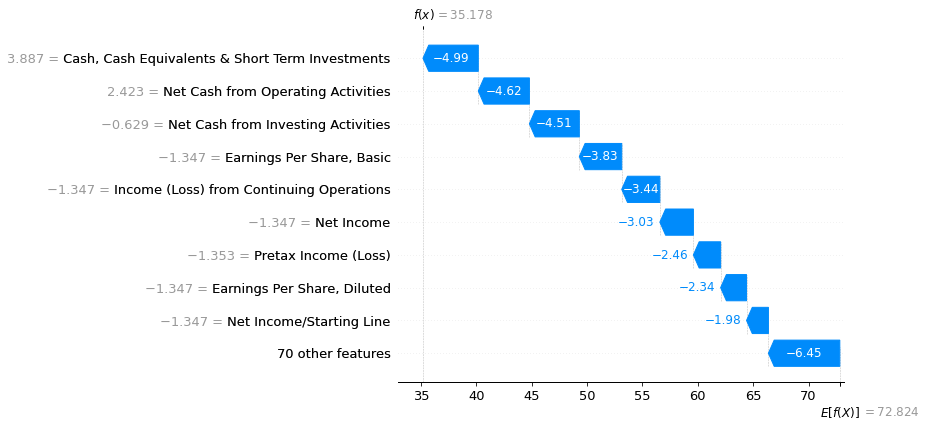

In [70]:
explainer = shap.TreeExplainer(common_model)
max_date = df.index.get_level_values(1).max()
shap_values = explainer(df.loc[(slice('ELY','ELY'), slice(max_date, max_date)),:].drop(['Close', 'Predicted Close', 'Model'], axis=1)  )[0]
shap.waterfall_plot(shap_values)

In [ ]:
sns.lineplot?

In [ ]:
df.loc['AAME'][['Close', 'Predicted Close']]

In [ ]:
df.loc[(slice('UVE','UVE'), slice(max_date, max_date)),:].drop(['Predicted Close', 'Model'], axis=1)

In [ ]:
pred_df['1 Year Change'] = pred_df.groupby(
    'Ticker')['Close'].pct_change(12).shift(-12)

pred_df['Perc of Close'] = pred_df['Pred Close'].div(pred_df['Close'])
pred_df = pred_df.dropna()


In [ ]:
pred_df

In [ ]:
(pred_df['Pred Close'] / pred_df['Close']) - 1

In [ ]:
from  matplotlib.ticker import PercentFormatter

g = sns.scatterplot(data=sf.winsorize(pred_df[['Perc of Close', '1 Year Change', 'Ticker']],
                                  quantile=.05, clip=False, exclude_columns=['Ticker']), x='Perc of Close', y='1 Year Change')


g.yaxis.set_major_formatter(PercentFormatter(1))
g.xaxis.set_major_formatter(PercentFormatter(1))

In [ ]:
pred_df[pred_df.Date == pred_df.Date.max()].sort_values(by='1 Year Change', ascending=False).head(50)